In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn

In [4]:
# 데이터 로드
# save_path = "~/work/DKTC/"
save_path = "../"

train_df = pd.read_csv(save_path + 'data/train_preprocseeing_0210_2.csv')
test_df = pd.read_csv(save_path + 'data/test_preprocseeing_0210_3.csv')
submission_df = pd.read_csv(save_path + 'data/submission.csv')

In [7]:
train_df.loc[train_df['class'] == '협박 대화', 'class'] = 0
train_df.loc[train_df['class'] == '갈취 대화', 'class'] = 1
train_df.loc[train_df['class'] == '직장 내 괴롭힘 대화', 'class'] = 2
train_df.loc[train_df['class'] == '기타 괴롭힘 대화', 'class'] = 3
#train_df.loc[train_df['class'] == '일반 대화', 'class'] = 4

TypeError: Invalid value '0' for dtype 'str'. Value should be a string or missing value, got 'int' instead.

In [4]:
pd.set_option('display.unicode.east_asian_width', True)
print("[Class Distribution]")
print(train_df['class'].value_counts())

print("=" * 100)

# 데이터 예시
display(train_df.head(5))

[Class Distribution]
class
3    1010
1     973
2     970
0     892
Name: count, dtype: int64


,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## 사전 학습된 모델 불러오기

In [5]:
# RoBERTa
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

roberta_model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-small", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-small")

Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: klue/roberta-small
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [6]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("klue/roberta-small")
print(config)

RobertaConfig {
  "_attn_implementation_autoset": true,
  "add_cross_attention": false,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "dtype": "float32",
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "neuron": {
    "auto_cast": null,
    "auto_cast_type": null,
    "compiler_type": "neuronx-cc",
    "compiler_version": "2.19.8089.0+8ab9f450",
    "disable_fallback": false,
    "disable_fast_relayout": false,
    "dynamic_batch_size": false,
    "inline_weights_to_neff": true,
    "input_names": [
      "input_ids",
      "attention_mask"
    ],
    "model_type": "roberta",
    "optlevel": "2",
    "output_attentions": false,
    "output_

## Dataloader

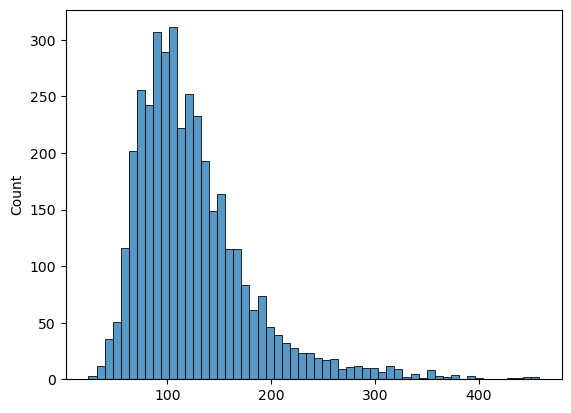

log value : 235.73571239477968


In [7]:
import seaborn as sns

tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train_df['conversation']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+2*np.std(tokenizer_len)}')

In [8]:


class CleanTalkDataset(Dataset):
    def __init__(self, data, labels, is_trainable, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.data = []
        self.labels = labels
        self.trainable = is_trainable

        self.data = [tokenizer(text, padding='max_length', max_length=235, truncation=True, add_special_tokens=True, return_tensors='pt') for text in data.values]
       

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.trainable:
            target = torch.tensor(self.labels.values[idx])
            return sample, target

        else: 
            return sample, torch.tensor([-1])

In [9]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_val = train_test_split(train_df, test_size = 0.2, shuffle = True, random_state = 42)

train_dataset = CleanTalkDataset(dataset_train['conversation'],dataset_train['class'], True, tokenizer)
val_dataset = CleanTalkDataset(dataset_val['conversation'], dataset_val['class'], True, tokenizer)

for text, label  in train_dataset:

    print(text)
    print(label)

    break

{'input_ids': tensor([[    0,  1521,  8340,  2051,    35,  3614,    18,  1460,    18,    35,
          3614,  1521,  2118,  2847,  6076,  1891,   823,  1689, 10554,  1902,
         13964,  1521,  8240,  2847,  5882,  2299,   746,  1565,  6186,   859,
          2918,  2203,    18,  1058,    35,  4766,    18,    35,  1460, 12803,
            18,  1460, 14670,  2411,  4181, 13911,  2377,  2052,  5429,  2173,
          2112,  4224,  1460,   717,  2138, 11287,    18,  5057,   732,   676,
          2126,  2073,   732,  2116,  1889, 23548,  3770,  1889,  2259,  2180,
          2275,    18, 22819,  1513,  2118,    35,  4785,  1565,  2259,  2180,
          2259, 16733,    18,  1058,  2315,   743,  2116,  1085,  2449,  2918,
          6076,   732,  2116, 24786,  3254,  2062,   743, 11287,  2776,  2318,
         10604,  5110,  2118,    18,    35, 16733,    18,  3839, 27841,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

In [11]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=False)

for text, label in train_dataloader:
    print(text['input_ids'].size())
    print(text['attention_mask'].size())
    print(label.size())
    break

torch.Size([64, 1, 235])
torch.Size([64, 1, 235])
torch.Size([64])


## 모델 학습

In [12]:
from tqdm import tqdm

def model_train(model, train_dataloader, val_dataloader, learning_rate, epochs, patiece, model_nm):
    best_acc = 0
    early_stopping_threshold_count = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)  # cuda 또는 cpu 출력
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    
    total_acc_train = []
    total_loss_train = []
    total_acc_val = []
    total_loss_val = []
    
    for epoch in range(epochs):
        
        train_loss_=0.0
        total = 0.0
        correct = 0.0
        
        model.train() # sets into the training mode
        
        for train_input, label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].squeeze(1).to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            label = label.to(device)

            optimizer.zero_grad()
            
            output = model(input_ids, attention_mask) # from the forward function
            #print(output[0])
            loss = criterion(output.logits, label) 
            loss.backward()
            optimizer.step()
            
            train_loss_ += loss.item()

            preds = output[0].argmax(dim=-1)
            correct += (preds == label).sum().item()
            #correct += calc_accuracy(output[0], label)
            total += label.size(0)
            
        total_loss_train.append(train_loss_ / len(train_dataloader))
        total_acc_train.append(correct / total)
        
        print(f'Epochs: {epoch + 1} '
              f'| Train Loss: {total_loss_train[-1] : .3f} '
              f'| Train Accuracy: {total_acc_train[-1] : .3f} ')

        with torch.no_grad(): # since we should not change gradient for validation 

            val_loss = 0.0
            val_total = 0.0
            val_correct = 0.0
            
            model.eval() # deactivate training
            
            # same process as the above
            for val_input, label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].squeeze(1).to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                label = label.to(device)
                
                output = model(input_ids, attention_mask) # from the forward function

                loss = criterion(output.logits, label) 
                val_loss += loss.item()

                preds = output[0].argmax(dim=-1)
                val_correct += (preds == label).sum().item()
                val_total += label.size(0)
                
        total_loss_val.append(val_loss / len(val_dataloader))
        total_acc_val.append(val_correct / val_total)
            
        print(
              f'| Val Loss: {total_loss_val[-1]: .3f} '
              f'| Val Accuracy: {total_acc_val[-1]: .3f}')
            
        if best_acc < total_acc_val[-1]:
            best_acc = total_acc_val[-1] # saving only the best one
            torch.save(model,f"{model_nm}.pt")
            print("Saved model")
            early_stopping_threshold_count = 0
        else:
            early_stopping_threshold_count += 1 # checking how many epochs have passed that val_loss didn't increase
            
        if early_stopping_threshold_count >= patience: # ==> patience=1
            print("Early stopping")
            break

    return total_loss_train, total_acc_train, total_loss_val, total_acc_val

In [13]:
model = roberta_model
model_nm = 'third_model' # 저장할 모델 이름
learning_rate = 0.00001
epochs = 2
patience = 5

total_loss_train, total_acc_train, total_loss_val, total_acc_val = model_train(model, train_dataloader, val_dataloader, learning_rate, epochs, patience, model_nm)

cuda


100%|██████████| 49/49 [01:01<00:00,  1.25s/it]


Epochs: 1 | Train Loss:  1.167 | Train Accuracy:  0.619 


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


| Val Loss:  0.681 | Val Accuracy:  0.818
Saved model


100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


Epochs: 2 | Train Loss:  0.511 | Train Accuracy:  0.861 


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


| Val Loss:  0.412 | Val Accuracy:  0.867
Saved model


## 모델 history 저장

In [14]:
import pickle

history = {'train_acc': total_acc_train}
history['train_loss'] = total_loss_train
history['val_acc'] = total_acc_val
history['val_loss'] = total_loss_val

# save data
with open('model_history.pickle','wb') as fw:
    pickle.dump(history, fw)

## Test

In [15]:
test_dataset = CleanTalkDataset(test_df['conversation'],None, False,tokenizer)

test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=False)

for text, label in test_dataset:
    print(text['input_ids'].size())
    print(text['attention_mask'].size())

    break

torch.Size([1, 235])
torch.Size([1, 235])


## 저장한 모델 불러오기

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("third_model.pt", map_location=device, weights_only=False)
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [18]:
model.eval()
predict_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for test_input, _ in test_dataloader:
        attention_mask = test_input['attention_mask'].squeeze(1).to(device)
        input_ids = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_ids, attention_mask) # from the forward function
        preds = output[0].argmax(dim=-1)
        predict_list.append(preds)
        
predict_list = torch.cat(predict_list).cpu().detach().numpy()

## Submission 파일 생성

In [19]:
submission_df['class'] = predict_list
submission_df

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,2


In [19]:
submission_df.to_csv("0211_3_submission.csv", index=False)

### GPU 메모리 정리

In [41]:
import gc
gc.collect()
torch.cuda.empty_cache()